In [ ]:
!conda install tensorflow

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
base_ds = 'Rice_Image_Dataset'
base_ds = pathlib.Path(base_ds)

In [8]:
splitfolders.ratio(base_ds, output='imgs', seed=123, ratio=(.7,.15,.15), group_prefix=None)

Copying files: 75000 files [16:06, 77.60 files/s] 


In [5]:
arborio = [fn for fn in os.listdir(f'{base_ds}/Arborio') if fn.endswith('.jpg')]
bastmati = [fn for fn in os.listdir(f'{base_ds}/Basmati') if fn.endswith('.jpg')]
ipsala = [fn for fn in os.listdir(f'{base_ds}/Ipsala') if fn.endswith('.jpg')]
jasmine = [fn for fn in os.listdir(f'{base_ds}/Jasmine') if fn.endswith('.jpg')]
karacadag = [fn for fn in os.listdir(f'{base_ds}/Karacadag') if fn.endswith('.jpg')]
rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = []
for i in os.listdir('imgs/train'):
    rice_classes+=[i]
rice_classes.sort()

Total images: 75000
Total number of classes: 5
Total Arborio images: 15000
Total Basmati images: 15000
Total Ipsala images: 15000
Total Jasmine images: 15000
Total Karacadag images: 15000


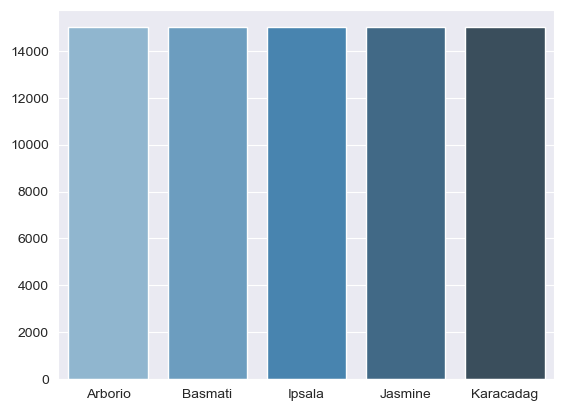

In [6]:
image_count = len(list(base_ds.glob('*/*.jpg')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(rice_classes)}')
count = 0
rice_count = []
for x in rice_classes:
  print(f'Total {x} images: {len(rice[count])}')
  rice_count.append(len(rice[count]))
  count += 1

sns.set_style('darkgrid')
sns.barplot(x=rice_classes, y=rice_count, palette="Blues_d")
plt.show()

Image dimensions: (250, 250, 3)


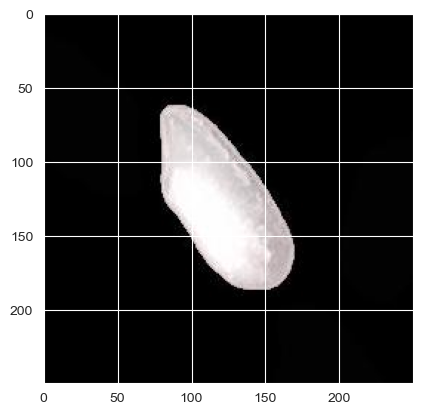

In [7]:
# =================================================== SAMPLES ==============================================================

sample_img = cv2.imread('imgs/test/Arborio/Arborio (10).jpg')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [8]:
def load_random_img(dir, label):
  plt.figure(figsize=(10,10))
  i=0
  for label in rice_classes:
    i+=1
    plt.subplot(1, 5, i)
    file = random.choice(os.listdir(f'{dir}/{label}'))
    image_path = os.path.join(f'{dir}/{label}', file)
    img=cv2.imread(image_path)
    plt.title(label)
    plt.imshow(img)
    plt.grid(None)
    plt.axis('off')

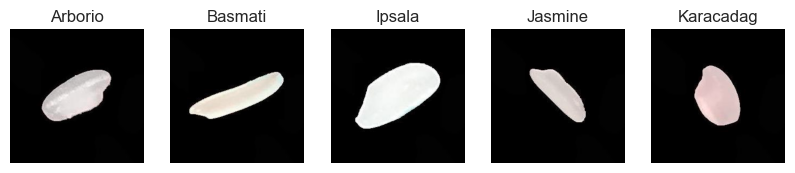

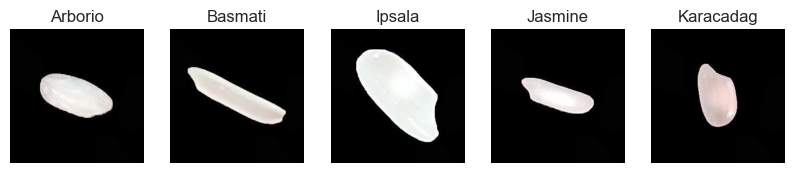

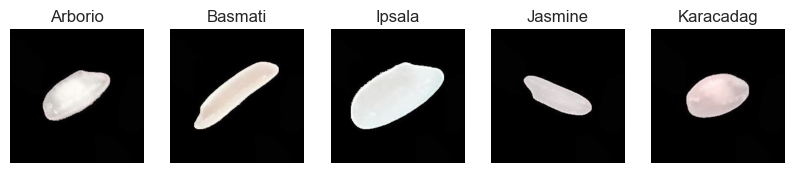

In [9]:
for i in range(3):
  load_random_img(base_ds, rice_classes)

In [10]:
batch_size = 128
img_height, img_width = 175, 175
input_shape = (img_height, img_width, 3)

In [11]:
datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 52500 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


In [13]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [14]:
model_vanilla = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    tf.keras.layers.BatchNormalization(axis = 3),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(5, activation='softmax')])

In [15]:
model_vanilla.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vanilla.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history1 = model_vanilla.fit(train_ds, epochs = 2, validation_data = val_ds, callbacks=callbacks)

Epoch 1/2


In [ ]:
model_vanilla.load_weights('saved_models/model_vanilla.hdf5')
plot_train_history(history1)

In [ ]:
# =================================================== MODEL EVALUATION =========================================================
score1 = model_vanilla.evaluate(test_ds, verbose=1)
Y_pred = model_vanillapredict(test_ds)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
report1 = classification_report(test_ds.classes, y_pred, target_names=rice_classes, output_dict=True)
df1 = pd.DataFrame(report1).transpose()

In [ ]:
# =================================================== MODEL CHECKING =========================================================
df1

In [16]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58889256/58889256 [==============================] - 5s 0us/step


In [17]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 dense_4 (Dense)             (None, 5)                 5125      
                                                                 
Total params: 15,245,125
Trainable params: 530,437
Non-trainable params: 14,714,688
___________________________________________

In [19]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history2 = model_vgg16.fit(train_ds, epochs = 2, validation_data = val_ds, callbacks=callbacks)

Epoch 1/2


In [ ]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

In [ ]:
plot_train_history(history2)

In [ ]:
# =================================================== FINE TUNING =========================================================

vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

history3 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

In [ ]:
score3 = model_vgg16.evaluate(test_ds, verbose=1)
print(f'Model 1 Vanilla Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'Model 2 VGG16 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'Model 2 VGG16 Fine-tuned Loss: {score3[0]}, Accuracy: {score3[1]*100}')

In [ ]:
Y_pred = model_vgg16.predict(test_ds)

In [ ]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(rice_classes)
plt.title("Confusion Matrix")
plt.show() # showing results

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_ds.next()
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)